In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')


# 데이터 로드 (이전 단계에서 생성한 파일 사용)
df = pd.read_csv("merged_population_data.csv")

#--- Feature Engineering ---
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
# '주변시세 평균'은 '주변시세 평균(만원)'과 중복되므로 제거
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')


# 0으로 나누기 오류 방지
df['분양가(만원)'].replace(0, 1, inplace=True)
df['공급면적(㎡)'].replace(0, 1, inplace=True)
df['주변시세 평균(만원)'].replace(0, 1, inplace=True)
df['세대수'].replace(0, 1, inplace=True)


# 파생 변수 생성
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)

df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan)
df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['세대당면적'] = df['공급면적(㎡)'] / df['세대수']
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)

# '금리' 변수가 존재할 경우에만 '금리구간' 생성
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                            labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False)


#--- 모델링 준비 ---
# 학습용 데이터 구성
target = '분양률'
# 분양률과 직접적으로 관련된 변수 및 사용된 변수 제거
drop_cols = infra_cols + ['주변시세 평균(만원)', '시세차익(만원)', '분양률']
X = df.drop(columns=drop_cols, errors='ignore')
y = df[target]

# 결측치가 있는 행 제거 (분양률 타겟)
y.fillna(y.mean(), inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 숫자형, 범주형 피처 구분
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()


#--- 전처리 및 모델 파이프라인 ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
    remainder='passthrough'
)


# 모델 정의
pipe_lgbm = Pipeline([('preprocessor', preprocessor), ('regressor', lgb.LGBMRegressor(random_state=42))])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(random_state=42))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

# 하이퍼파라미터 탐색 공간
param_dist_lgbm = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7, -1],
    'regressor__num_leaves': [15, 31, 63]
}
param_dist_xgb = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.7, 0.8, 0.9]
}
param_dist_rf = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5, 10]
}

# RandomizedSearchCV 실행
print("🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...")
search_lgbm = RandomizedSearchCV(pipe_lgbm, param_dist_lgbm, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_xgb = RandomizedSearchCV(pipe_xgb, param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_rf = RandomizedSearchCV(pipe_rf, param_dist_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')

search_lgbm.fit(X_train, y_train)
print("✅ LightGBM 최적화 완료")
search_xgb.fit(X_train, y_train)
print("✅ XGBoost 최적화 완료")
search_rf.fit(X_train, y_train)
print("✅ RandomForest 최적화 완료")

# 최적 모델 추출
best_lgbm = search_lgbm.best_estimator_
best_xgb = search_xgb.best_estimator_
best_rf = search_rf.best_estimator_

#--- 스태킹 모델 ---
print("\n🔥 스태킹 모델 훈련을 시작합니다...")
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    cv=3,
    n_jobs=-1
)
stack_model.fit(X_train, y_train)

#--- 최종 평가 ---
y_pred = stack_model.predict(X_test)
print("\n🏁 최종 성능 결과:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2933
[LightGBM] [Info] Total Bins 2921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2923
[LightGBM] [Info] T

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 1. 데이터 로드 및 전처리
df = pd.read_csv("merged_population_data.csv")

# Feature Engineering
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')

# 0으로 나누기 오류 방지
for col in ['분양가(만원)', '공급면적(㎡)', '주변시세 평균(만원)', '세대수']:
    if col in df.columns:
        df[col].replace(0, 1, inplace=True)

# 파생 변수 생성
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan)
df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['세대당면적'] = df['공급면적(㎡)'] / df['세대수']
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                            labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False)

# 2. 학습용 데이터 구성
target = '분양률'
drop_cols = infra_cols + ['주변시세 평균(만원)', '시세차익(만원)', '분양률']
X = df.drop(columns=drop_cols, errors='ignore')
y = df[target]
y.fillna(y.mean(), inplace=True)

# ⭐️ 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. 전처리 파이프라인
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
    remainder='passthrough'
)

# 4. 과대적합을 위한 결정 트리 모델 정의
tree_model = DecisionTreeRegressor(random_state=42)
overfit_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', tree_model)])

# 5. 훈련 데이터로 모델 훈련
print("🚀 결정 트리 모델을 훈련 데이터로 훈련시킵니다...")
overfit_pipeline.fit(X_train, y_train)
print("✅ 훈련 완료.")

# 6. 훈련 세트와 테스트 세트 양쪽 모두에서 성능 평가
y_pred_train = overfit_pipeline.predict(X_train)
y_pred_test = overfit_pipeline.predict(X_test)

print("\n--- 훈련 세트 성능 (Train Set Performance) ---")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"R² Score: {r2_score(y_train, y_pred_train):.4f}")

print("\n--- 테스트 세트 성능 (Test Set Performance) ---")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred_test):.4f}")

🚀 결정 트리 모델을 훈련 데이터로 훈련시킵니다...
✅ 훈련 완료.

--- 훈련 세트 성능 (Train Set Performance) ---
MSE: 0.0000
MAE: 0.0000
R² Score: 1.0000

--- 테스트 세트 성능 (Test Set Performance) ---
MSE: 0.0656
MAE: 0.1268
R² Score: 0.3124


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214 entries, 0 to 2213
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   지역                 2214 non-null   object  
 1   아파트                2214 non-null   object  
 2   공급면적(㎡)            2214 non-null   float64 
 3   전용면적(㎡)            2214 non-null   float64 
 4   일반분양               2214 non-null   int64   
 5   특별분양               2214 non-null   int64   
 6   세대수                2214 non-null   int64   
 7   분양가(만원)            2214 non-null   int64   
 8   분양률                2214 non-null   float64 
 9   준공여부               2214 non-null   object  
 10  건설사                2214 non-null   object  
 11  금리                 2214 non-null   float64 
 12  환율                 2214 non-null   float64 
 13  대형마트 - 1.5km 이내    2214 non-null   int64   
 14  대형쇼핑 - 3km 이내      2214 non-null   int64   
 15  편의점 - 500m 이내      2214 non-null   int64   
 16  은행 - 1

In [6]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
import warnings
from tqdm.auto import tqdm

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# ---------------------------------
# 1. 텍스트 임베딩을 위한 함수 정의
# ---------------------------------
def get_kobert_embeddings(data, model, tokenizer):
    """KoBERT 모델을 사용하여 텍스트 데이터에서 임베딩을 추출하는 함수"""
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
        with torch.no_grad():
            outputs = model(**inputs)
        # [CLS] 토큰의 임베딩을 사용
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# ---------------------------------
# 2. 데이터 로드 및 기본 전처리
# ---------------------------------
df = pd.read_csv("merged_population_data.csv")

# Feature Engineering (이전과 동일)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')
for col in ['분양가(만원)', '공급면적(㎡)', '주변시세 평균(만원)', '세대수']:
    if col in df.columns:
        df[col].replace(0, 1, inplace=True)
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan)
df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['세대당면적'] = df['공급면적(㎡)'] / df['세대수']
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                            labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False)

# ---------------------------------
# 3. KoBERT 임베딩 생성 및 데이터 결합
# ---------------------------------
print("🤖 KoBERT 모델과 토크나이저를 로드합니다...")
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1")
model = AutoModel.from_pretrained("skt/kobert-base-v1")

# '아파트'와 '건설사' 이름에 대한 임베딩 생성
apt_embeddings = get_kobert_embeddings(df['아파트'], model, tokenizer)
co_embeddings = get_kobert_embeddings(df['건설사'], model, tokenizer)

# 임베딩 결과를 DataFrame으로 변환
apt_embed_df = pd.DataFrame(apt_embeddings, columns=[f'apt_embed_{i}' for i in range(apt_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])

# 기존 데이터와 임베딩 데이터 결합
df_processed = pd.concat([df, apt_embed_df, co_embed_df], axis=1)

# ---------------------------------
# 4. 모델링 준비
# ---------------------------------
target = '분양률'
# 임베딩에 사용된 원본 텍스트 컬럼과 불필요한 컬럼 제거
drop_cols = infra_cols + ['아파트', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 이제 임베딩 컬럼은 모두 숫자형이므로, 숫자형 피처에 포함됨
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# ---------------------------------
# 5. 전처리 및 모델 파이프라인 (이전과 동일)
# ---------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
    remainder='passthrough'
)

pipe_lgbm = Pipeline([('preprocessor', preprocessor), ('regressor', lgb.LGBMRegressor(random_state=42))])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(random_state=42))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

param_dist_lgbm = {'regressor__n_estimators': [300, 500], 'regressor__learning_rate': [0.05, 0.1], 'regressor__max_depth': [5, 7], 'regressor__num_leaves': [31, 63]}
param_dist_xgb = {'regressor__n_estimators': [300, 500], 'regressor__learning_rate': [0.05, 0.1], 'regressor__max_depth': [5, 7], 'regressor__subsample': [0.8, 0.9]}
param_dist_rf = {'regressor__n_estimators': [300, 500], 'regressor__max_depth': [10, None], 'regressor__min_samples_split': [2, 5]}

print("\n🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...")
search_lgbm = RandomizedSearchCV(pipe_lgbm, param_dist_lgbm, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_xgb = RandomizedSearchCV(pipe_xgb, param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_rf = RandomizedSearchCV(pipe_rf, param_dist_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')

search_lgbm.fit(X_train, y_train)
print("✅ LightGBM 최적화 완료")
search_xgb.fit(X_train, y_train)
print("✅ XGBoost 최적화 완료")
search_rf.fit(X_train, y_train)
print("✅ RandomForest 최적화 완료")

best_lgbm = search_lgbm.best_estimator_
best_xgb = search_xgb.best_estimator_
best_rf = search_rf.best_estimator_

# ---------------------------------
# 6. 스태킹 모델 및 최종 평가
# ---------------------------------
print("\n🔥 스태킹 모델 훈련을 시작합니다...")
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    cv=3,
    passthrough=True,
    n_jobs=-1
)
stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)
print("\n🏁 최종 성능 결과 (텍스트 임베딩 적용):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

ImportError: tokenizers>=0.14,<0.19 is required for a normal functioning of this module, but found tokenizers==0.21.2.
Try: pip install transformers -U or pip install -e '.[dev]' if you're working with git main

In [ ]:
import pandas as pd

def preprocess_population_data(file_path):
    """
    3중 헤더를 가진 인구 데이터를 전처리하는 함수입니다.
    '총인구수'와 '인구증감률'만 추출하여 데이터를 재구조화합니다.
    """
    df = pd.read_csv(file_path, header=[0, 1, 2], encoding='utf-8')

    region_col_name = df.columns[0]
    region_df = df[[region_col_name]]
    region_df.columns = ['지역']

    data_df = df.iloc[:, 1:]

    df_total_pop = data_df.xs('총인구수 (명)', level=1, axis=1)

    df_raw_data = df_total_pop.xs('원데이터', level=1, axis=1)
    df_rate_data = df_total_pop.xs('증감률', level=1, axis=1)

    df_raw = pd.concat([region_df, df_raw_data], axis=1)
    df_rate = pd.concat([region_df, df_rate_data], axis=1)

    pop_melted = df_raw.melt(id_vars='지역', var_name='기준년월', value_name='총인구수')
    rate_melted = df_rate.melt(id_vars='지역', var_name='기준년월', value_name='인구증감률')

    processed_df = pd.merge(pop_melted, rate_melted, on=['지역', '기준년월'])

    processed_df['기준년월'] = pd.to_datetime(processed_df['기준년월'], format='%Y.%m').dt.strftime('%Y-%m')
    processed_df['지역'] = processed_df['지역'].apply(lambda x: str(x).split('(')[0].strip())
    
    return processed_df

def merge_data(final_data_path, pop_data_df):
    """
    기존 데이터와 인구 데이터를 병합하는 함수입니다.
    """
    df_final = pd.read_csv(final_data_path)

    df_final['기준년월'] = pd.to_datetime(df_final['기준년월']).dt.strftime('%Y-%m')

    # '지역' 컬럼의 값 형식을 통일합니다.
    # '인구.csv'의 '특별자치도' 등을 'final_merged_data.csv'의 '도' 형식으로 맞춰줍니다.
    # 예: "강원특별자치도" -> "강원도"
    name_mapping = {
        '강원특별자치도': '강원도',
        '전북특별자치도': '전라북도', # '전북특별자치도'는 '전라북도'로 변경
        '제주특별자치도': '제주도'
    }
    pop_data_df['지역'] = pop_data_df['지역'].replace(name_mapping)

    # '기준년월'과 '지역'을 기준으로 두 데이터를 병합합니다.
    merged_df = pd.merge(df_final, pop_data_df, on=['기준년월', '지역'], how='left')

    return merged_df

# --- 스크립트 실행 부분 ---

# 파일 경로 설정
population_file = '인구.csv'
final_data_file = 'final_merged_data.csv'
output_file = 'merged_population_data.csv'

# 1. 인구 데이터 전처리
processed_pop_df = preprocess_population_data(population_file)

# 2. 전처리된 인구 데이터와 기존 데이터 병합
final_merged_df = merge_data(final_data_file, processed_pop_df)

# 결과 확인
print("--- 병합 후 데이터 샘플 (상위 5개) ---")
print(final_merged_df.head())

print("\n--- NaN이 아닌 데이터가 있는지 확인 (총인구수 기준) ---")
print(final_merged_df.dropna(subset=['총인구수']).head())


# 결과를 CSV 파일로 저장
final_merged_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n✅ 성공적으로 데이터를 병합하여 '{output_file}' 파일로 저장했습니다.")

--- 병합 후 데이터 샘플 (상위 5개) ---
      기준년월   지역        아파트  공급면적(㎡)  전용면적(㎡)  일반분양  특별분양  세대수  미분양수  분양가(만원)  \
0  2025-04  강원도  강릉자이르네디오션   109.54    84.88    26    27   53     2    57590   
1  2025-04  강원도  강릉자이르네디오션   109.96    84.98    10    11   21     0    50260   
2  2025-04  강원도  강릉자이르네디오션   109.97    84.98    11    15   26     1    56360   
3  2025-04  강원도  강릉자이르네디오션   111.15    84.92    19    21   40     3    53700   
4  2025-04  강원도  강릉자이르네디오션   131.96   101.96     2     0    2     0    72320   

   ...  버스 - 반경 500m 이내 고속철도 - 10km 이내 고속도로IC - 10km 이내  주변시세 평균  주변시세 평균(만원)  \
0  ...                0              1                3      3.9        39000   
1  ...                0              1                3      3.9        39000   
2  ...                0              1                3      3.9        39000   
3  ...                0              1                3      3.9        39000   
4  ...                0              1                3      3.9        39000   

   시

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# 1. 텍스트 임베딩 함수 (이전과 동일)
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# 2. 데이터 로드 및 특성 공학 (이전과 동일)
df = pd.read_csv("merged_population_data.csv")
# ... (이전 코드와 동일한 특성 공학 과정) ...
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')
for col in ['분양가(만원)', '공급면적(㎡)', '주변시세 평균(만원)', '세대수']:
    if col in df.columns:
        df[col].replace(0, 1, inplace=True)
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan)
df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['세대당면적'] = df['공급면적(㎡)'] / df['세대수']
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                            labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False)

# 3. 임베딩 생성 (이전과 동일)
MODEL_NAME = "kykim/bert-kor-base"
print(f"🤖 '{MODEL_NAME}' 모델과 토크나이저를 로드합니다...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
apt_embeddings = get_embeddings(df['아파트'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
apt_embed_df = pd.DataFrame(apt_embeddings, columns=[f'apt_embed_{i}' for i in range(apt_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), apt_embed_df, co_embed_df], axis=1)

# 4. 모델링 준비 (이전과 동일)
target = '분양률'
drop_cols = infra_cols + ['아파트', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# 5. 전처리 단계
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
    remainder='passthrough'
)

print("\n데이터 전처리를 시작합니다...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")

# ⭐️ 6. 훈련 데이터 상태 확인
# --------------------------------
print("\n--- 훈련 전 데이터 상태 확인 ---")
print(f"독립 변수(X_train_processed) 타입: {type(X_train_processed)}")
print(f"독립 변수(X_train_processed) 형태: {X_train_processed.shape}")
print(f"독립 변수 내 NaN 개수: {np.isnan(X_train_processed).sum()}")
print(f"\n종속 변수(y_train) 타입: {type(y_train)}")
print(f"종속 변수(y_train) 형태: {y_train.shape}")
print(f"종속 변수 내 NaN 개수: {y_train.isnull().sum()}")
print("---------------------------------")



🤖 'kykim/bert-kor-base' 모델과 토크나이저를 로드합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]


데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

--- 훈련 전 데이터 상태 확인 ---
독립 변수(X_train_processed) 타입: <class 'numpy.ndarray'>
독립 변수(X_train_processed) 형태: (1771, 1582)
독립 변수 내 NaN 개수: 0

종속 변수(y_train) 타입: <class 'pandas.core.series.Series'>
종속 변수(y_train) 형태: (1771,)
종속 변수 내 NaN 개수: 0
---------------------------------


In [3]:

# 7. 하이퍼파라미터 탐색
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
xgb_model = xgb.XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
param_dist_lgbm = {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'num_leaves': [31, 63]}
param_dist_xgb = {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'subsample': [0.8, 0.9]}
param_dist_rf = {'n_estimators': [300, 500], 'max_depth': [10, None], 'min_samples_split': [2, 5]}

print("\n🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...")
search_lgbm = RandomizedSearchCV(lgbm, param_dist_lgbm, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_xgb = RandomizedSearchCV(xgb_model, param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')

search_lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 최적화 완료")
search_xgb.fit(X_train_processed, y_train)
print("✅ XGBoost 최적화 완료")
search_rf.fit(X_train_processed, y_train)
print("✅ RandomForest 최적화 완료")

best_lgbm = search_lgbm.best_estimator_
best_xgb = search_xgb.best_estimator_
best_rf = search_rf.best_estimator_

# 8. 스태킹 모델 및 최종 평가
print("\n🔥 스태킹 모델 훈련을 시작합니다...")
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    cv=3,
    passthrough=True,
    n_jobs=-1
)
stack_model.fit(X_train_processed, y_train)

y_pred = stack_model.predict(X_test_processed)
print("\n🏁 최종 성능 결과 (텍스트 임베딩 적용):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has alread

✅ LightGBM 최적화 완료
✅ XGBoost 최적화 완료
✅ RandomForest 최적화 완료

🔥 스태킹 모델 훈련을 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	


🏁 최종 성능 결과 (텍스트 임베딩 적용):
MSE: 0.0385
MAE: 0.1269
R² Score: 0.5970


🤖 'kykim/bert-kor-base' 모델과 토크나이저를 로드합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]


데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

✅ LightGBM 최적화 완료
✅ RandomForest 최적화 완료

📊 LightGBM 특성 중요도 분석:


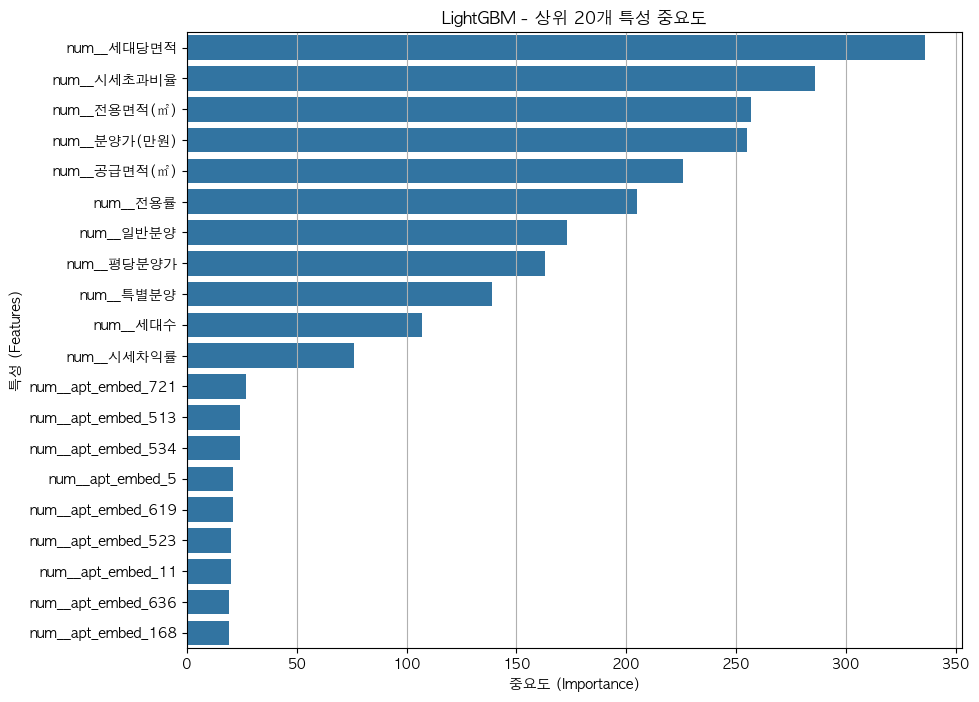


📊 RandomForest 특성 중요도 분석:


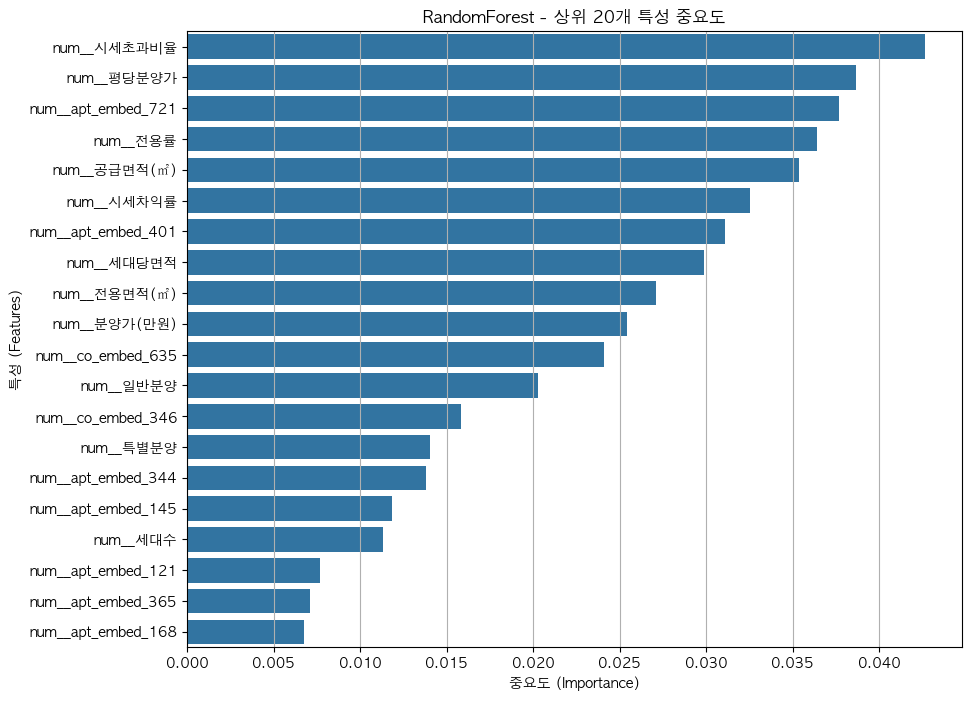

In [4]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm

# 한글 폰트 설정 (Mac OS 사용자)
# 윈도우 사용자의 경우, 'AppleGothic' 대신 'Malgun Gothic' 등을 사용하세요.
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지


warnings.filterwarnings('ignore')

# --- 이전 단계의 코드 요약 (데이터 준비) ---
# (이전 코드와 동일하므로, 간략하게 설명과 함께 재구성합니다)

# 1. 함수 및 데이터 로드
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중", leave=False):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

df = pd.read_csv("merged_population_data.csv")

# 2. 특성 공학
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')
for col in ['분양가(만원)', '공급면적(㎡)', '주변시세 평균(만원)', '세대수']:
    if col in df.columns:
        df[col].replace(0, 1, inplace=True)
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan)
df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['세대당면적'] = df['공급면적(㎡)'] / df['세대수']
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                            labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False)

# 3. 임베딩 및 데이터 결합
MODEL_NAME = "kykim/bert-kor-base"
print(f"🤖 '{MODEL_NAME}' 모델과 토크나이저를 로드합니다...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
apt_embeddings = get_embeddings(df['아파트'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
apt_embed_df = pd.DataFrame(apt_embeddings, columns=[f'apt_embed_{i}' for i in range(apt_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), apt_embed_df, co_embed_df], axis=1)

# 4. 모델링 데이터 준비
target = '분양률'
drop_cols = infra_cols + ['아파트', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# 5. 전처리
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
    remainder='passthrough' # passthrough 대신 drop으로 설정하여 명시적으로 관리
)
print("\n데이터 전처리를 시작합니다...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")

# 6. 하이퍼파라미터 탐색 및 최적 모델 훈련
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
rf = RandomForestRegressor(random_state=42)
param_dist_lgbm = {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'num_leaves': [31, 63]}
param_dist_rf = {'n_estimators': [300, 500], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
print("\n🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...")
search_lgbm = RandomizedSearchCV(lgbm, param_dist_lgbm, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 최적화 완료")
search_rf.fit(X_train_processed, y_train)
print("✅ RandomForest 최적화 완료")
best_lgbm = search_lgbm.best_estimator_
best_rf = search_rf.best_estimator_

# --- ⭐ 7. 특성 중요도 분석 및 시각화 ---

def plot_feature_importance(model, feature_names, model_name):
    """모델의 특성 중요도를 시각화하는 함수"""
    # 특성 중요도 시리즈 생성
    feature_importance = pd.Series(model.feature_importances_, index=feature_names)
    
    # 중요도 순으로 정렬
    top20 = feature_importance.sort_values(ascending=False).head(20)
    
    # 시각화
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top20.values, y=top20.index)
    plt.title(f'{model_name} - 상위 20개 특성 중요도')
    plt.xlabel('중요도 (Importance)')
    plt.ylabel('특성 (Features)')
    plt.grid(axis='x')
    plt.show()

# 전처리된 피처 이름 가져오기
processed_feature_names = preprocessor.get_feature_names_out()

# LightGBM 특성 중요도 시각화
print("\n📊 LightGBM 특성 중요도 분석:")
plot_feature_importance(best_lgbm, processed_feature_names, 'LightGBM')

# RandomForest 특성 중요도 시각화
print("\n📊 RandomForest 특성 중요도 분석:")
plot_feature_importance(best_rf, processed_feature_names, 'RandomForest')

In [8]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# 1. 텍스트 임베딩 함수 (이전과 동일)
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# ⭐️ 2. 우선순위를 적용한 브랜드 추출 함수 및 리스트 정의
def extract_brand(apt_name, brand_list):
    """아파트 이름에서 우선순위가 가장 높은 브랜드명을 추출하는 함수"""
    for brand in brand_list:
        if brand in apt_name:
            return brand  # 리스트의 앞 순서(더 높은 우선순위)에 있는 브랜드를 먼저 반환
    return '기타 브랜드'

# 국내 주요 아파트 브랜드 '우선순위' 리스트
brand_priority_list = [
    # --- 최상위 프리미엄 브랜드 ---
    '디에이치', '아크로', '르엘', '오티에르',
    # --- 1군 메이저 브랜드 ---
    '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    # --- 중견/강소 브랜드 ---
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디',
    '하늘채', '베르디움', '스위첸', '꿈에그린', '반도유보라', '제일풍경채', '금강펜테리움',
    '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘',
    '대방노블랜드', '대광로제비앙', '양우내안애', '경남아너스빌', '삼부르네상스', '한양수자인',
    '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌',
    # --- 서브 브랜드 및 단지명 특징 (가장 낮은 우선순위) ---
    '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]


# 3. 데이터 로드 및 특성 공학
df = pd.read_csv("merged_population_data.csv")
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')
for col in ['분양가(만원)', '공급면적(㎡)', '주변시세 평균(만원)', '세대수']:
    if col in df.columns:
        df[col].replace(0, 1, inplace=True)
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan)
df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['세대당면적'] = df['공급면적(㎡)'] / df['세대수']
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                            labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False)

# 4. 브랜드 추출 및 임베딩 생성
print("🏙️ 아파트 이름에서 브랜드를 추출합니다...")
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
print("--- 브랜드 추출 결과 (상위 5개) ---")
print(df[['아파트', '브랜드']].head())

MODEL_NAME = "kykim/bert-kor-base"
print(f"\n🤖 '{MODEL_NAME}' 모델과 토크나이저를 로드합니다...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)

brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])

df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)

# 5. 모델링 준비
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# 6. 전처리 및 모델 훈련
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ],
    remainder='passthrough'
)
print("\n데이터 전처리를 시작합니다...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")

lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
xgb_model = xgb.XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
param_dist_lgbm = {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'num_leaves': [31, 63]}
param_dist_xgb = {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'subsample': [0.8, 0.9]}
param_dist_rf = {'n_estimators': [300, 500], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
print("\n🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...")
search_lgbm = RandomizedSearchCV(lgbm, param_dist_lgbm, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_xgb = RandomizedSearchCV(xgb_model, param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 최적화 완료")
search_xgb.fit(X_train_processed, y_train)
print("✅ XGBoost 최적화 완료")
search_rf.fit(X_train_processed, y_train)
print("✅ RandomForest 최적화 완료")
best_lgbm = search_lgbm.best_estimator_
best_xgb = search_xgb.best_estimator_
best_rf = search_rf.best_estimator_

print("\n🔥 스태킹 모델 훈련을 시작합니다...")
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    cv=3,
    passthrough=True,
    n_jobs=-1
)
stack_model.fit(X_train_processed, y_train)

y_pred = stack_model.predict(X_test_processed)
print("\n🏁 최종 성능 결과 (브랜드 우선순위 임베딩 적용):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

🏙️ 아파트 이름에서 브랜드를 추출합니다...
--- 브랜드 추출 결과 (상위 5개) ---
         아파트 브랜드
0  강릉자이르네디오션  자이
1  강릉자이르네디오션  자이
2  강릉자이르네디오션  자이
3  강릉자이르네디오션  자이
4  강릉자이르네디오션  자이

🤖 'kykim/bert-kor-base' 모델과 토크나이저를 로드합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]


데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🚀 모델 최적화(RandomizedSearchCV)를 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISMhuggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before 

✅ LightGBM 최적화 완료
✅ XGBoost 최적화 완료
✅ RandomForest 최적화 완료

🔥 스태킹 모델 훈련을 시작합니다...

🏁 최종 성능 결과 (브랜드 우선순위 임베딩 적용):
MSE: 0.0398
MAE: 0.1314
R² Score: 0.5832


✅ 전체 데이터 2214개 중 10세대 미만인 이상치는 총 382개 입니다.

--- 이상치 데이터 기본 통계 ---
              세대수         분양률       분양가(만원)         평당분양가
count  382.000000  382.000000  3.820000e+02    382.000000
mean     3.421466    0.783529  8.656776e+04   1825.869275
std      2.523976    0.366730  1.379842e+05   1776.600982
min      1.000000    0.000000  0.000000e+00      0.000000
25%      1.000000    0.666667  2.735675e+04   1003.865819
50%      2.000000    1.000000  7.070000e+04   1566.289477
75%      6.000000    1.000000  1.103875e+05   2478.973748
max      9.000000    1.000000  1.600000e+06  15817.381145


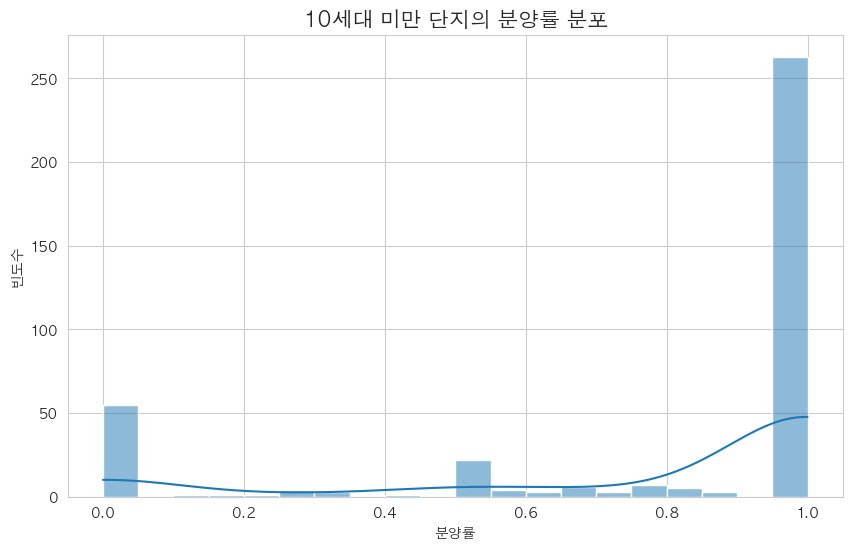

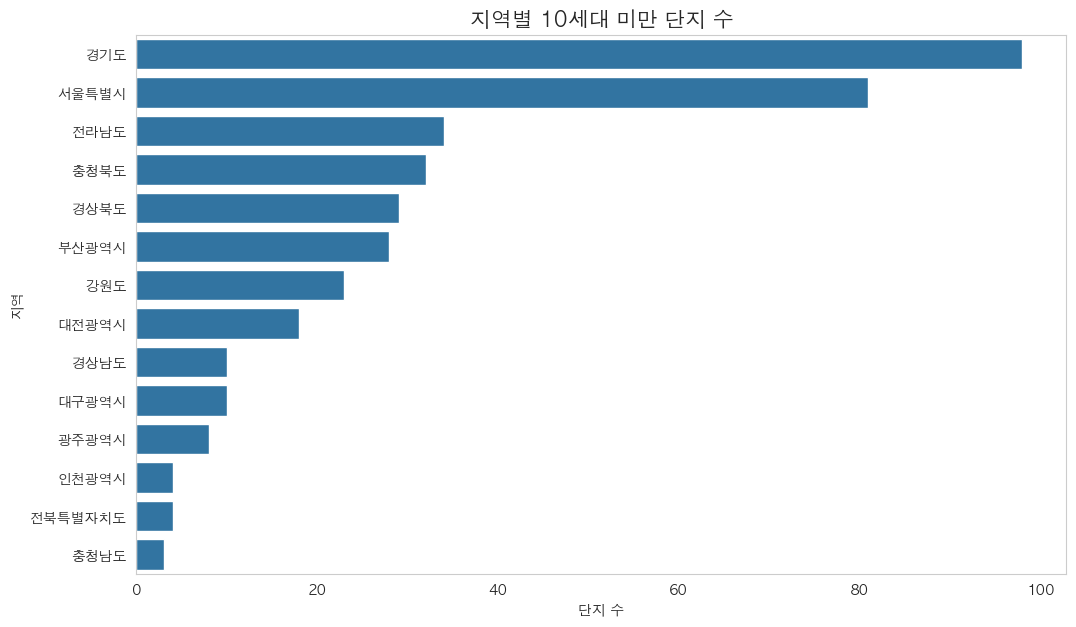

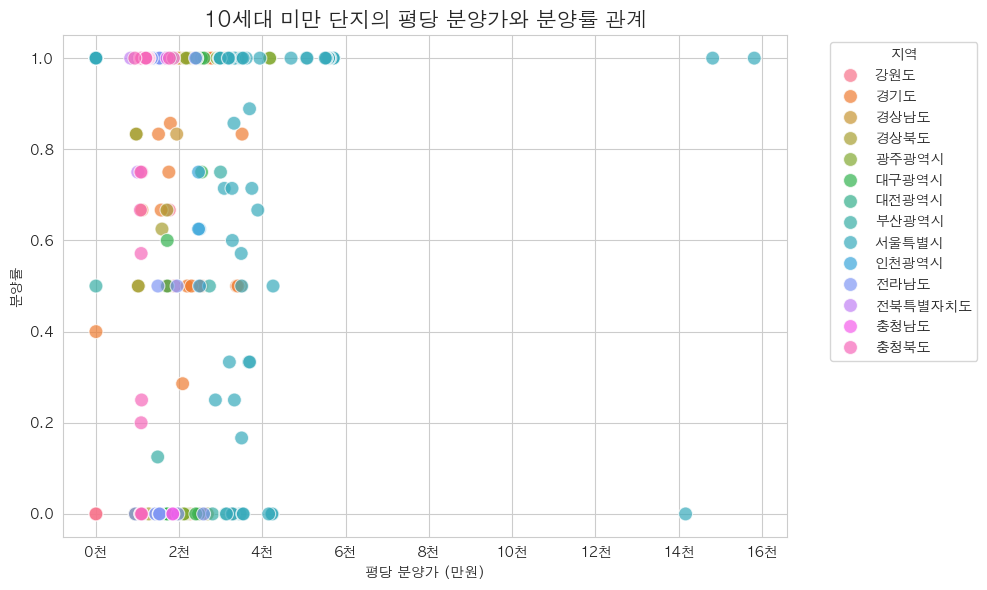

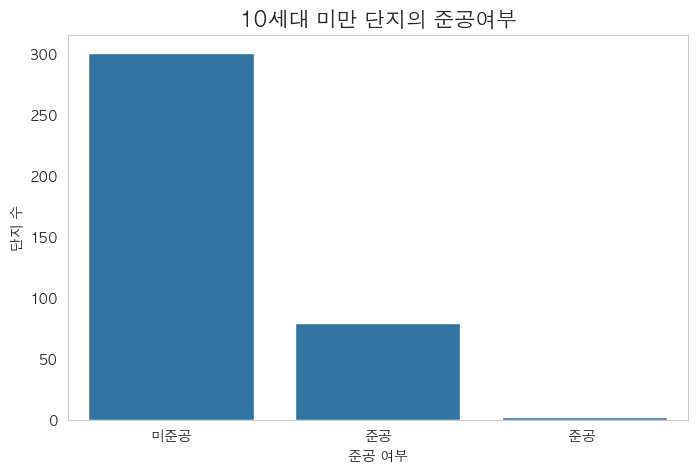

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# 1. 한글 폰트 및 시각화 스타일 설정
# ----------------------------------------------------
# Mac OS 사용자용 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 시각화 스타일 설정
sns.set_style('whitegrid')


# ----------------------------------------------------
# 2. 데이터 로드 및 이상치 필터링
# ----------------------------------------------------
file_path = 'final_data.csv'

try:
    df = pd.read_csv(file_path)

    # '세대수' 컬럼을 숫자로 변환 (오류 발생 시 NaN으로 처리)
    df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')
    
    # 10세대 미만인 데이터를 이상치(outliers)로 정의
    outliers_df = df[df['세대수'] < 10].copy() # .copy()를 사용하여 SettingWithCopyWarning 방지

    print(f"✅ 전체 데이터 {len(df)}개 중 10세대 미만인 이상치는 총 {len(outliers_df)}개 입니다.")
    
    # 평당분양가 계산 (분석을 위해 추가)
    outliers_df['평당분양가'] = (outliers_df['분양가(만원)'] / (outliers_df['공급면적(㎡)'] / 3.3)).replace([np.inf, -np.inf], np.nan)


    # ----------------------------------------------------
    # 3. EDA 및 시각화
    # ----------------------------------------------------
    if not outliers_df.empty:
        plt.rcParams['font.family'] = 'AppleGothic'
        plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지
        print("\n--- 이상치 데이터 기본 통계 ---")
        # 주요 수치형 데이터에 대한 통계 요약
        print(outliers_df[['세대수', '분양률', '분양가(만원)', '평당분양가']].describe())

        # --- 시각화 1: 분양률 분포 ---
        plt.figure(figsize=(10, 6))
        sns.histplot(outliers_df['분양률'], bins=20, kde=True)
        plt.title('10세대 미만 단지의 분양률 분포', fontsize=15)
        plt.xlabel('분양률')
        plt.ylabel('빈도수')
        plt.grid(True)
        plt.show()

        # --- 시각화 2: 지역별 이상치 분포 ---
        plt.figure(figsize=(12, 7))
        sns.countplot(y='지역', data=outliers_df, order=outliers_df['지역'].value_counts().index)
        plt.title('지역별 10세대 미만 단지 수', fontsize=15)
        plt.xlabel('단지 수')
        plt.ylabel('지역')
        plt.grid(axis='x')
        plt.show()
        
        # --- 시각화 3: 평당 분양가와 분양률의 관계 ---
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='평당분양가', y='분양률', data=outliers_df, hue='지역', s=100, alpha=0.7)
        plt.title('10세대 미만 단지의 평당 분양가와 분양률 관계', fontsize=15)
        plt.xlabel('평당 분양가 (만원)')
        plt.ylabel('분양률')
        plt.grid(True)
        # x축 단위를 천만 단위로 보기 쉽게 변경
        plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x/1000):,}천"))
        plt.legend(title='지역', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # --- 시각화 4: 준공여부 분포 ---
        plt.figure(figsize=(8, 5))
        sns.countplot(x='준공여부', data=outliers_df)
        plt.title('10세대 미만 단지의 준공여부', fontsize=15)
        plt.xlabel('준공 여부')
        plt.ylabel('단지 수')
        plt.grid(axis='y')
        plt.show()

    else:
        print("\n분석할 10세대 미만 데이터가 없습니다.")

except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 파일 이름을 다시 확인해 주세요.")
except KeyError as e:
    print(f"오류: '{e}' 컬럼을 찾을 수 없습니다. CSV 파일의 컬럼명을 확인해 주세요.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

In [14]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
import warnings
from tqdm.auto import tqdm

# 경고 메시지 무시
warnings.filterwarnings('ignore')


# 1. 텍스트 임베딩 함수 정의
def get_embeddings(data, model, tokenizer):
    """KoBERT 모델을 사용하여 텍스트 데이터에서 임베딩을 추출하는 함수"""
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# 2. 브랜드 추출 함수 및 우선순위 리스트 정의
def extract_brand(apt_name, brand_list):
    """아파트 이름에서 우선순위가 가장 높은 브랜드명을 추출하는 함수"""
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', 
    '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나', '어울림', '데시앙', '호반써밋', 
    '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린', 
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', 
    '쌍용예가', '이수브라운스톤', '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', 
    '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애', '경남아너스빌', 
    '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', 
    '모아엘가', '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', 
    '트리우스', '그라시엘', '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]


# 3. 데이터 로드 및 이상치 제거
df = pd.read_csv("final_data.csv")
print(f"이상치 제거 전 원본 데이터 행 수: {len(df)}")

# '세대수'를 숫자로 변환
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')

# 세대수가 10세대 미만인 경우를 이상치로 보고 제거
df = df[df['세대수'] >= 10].reset_index(drop=True)
print(f"이상치 제거 후 데이터 행 수: {len(df)}")


# 4. 최종 특성 공학 적용
print("\n🔬 최종 특성 공학을 적용합니다...")
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')

# 시간 관련 파생변수
df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['월'], inplace=True)

# 브랜드, 건설사 등급, 지역+브랜드 조합 특성
df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']

# 기존 특성 공학
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)


# 5. 임베딩 생성
MODEL_NAME = "kykim/bert-kor-base" 
print(f"\n🤖 '{MODEL_NAME}' 모델과 토크나이저를 로드합니다...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)

brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])

df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)


# 6. 모델링 준비
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()


# 7. 전처리
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ],
    remainder='passthrough'
)
print("\n데이터 전처리를 시작합니다...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# 8. GridSearchCV를 사용한 LightGBM 정밀 튜닝
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
param_grid_lgbm = {
    'n_estimators': [500, 700], 'learning_rate': [0.01, 0.05], 'max_depth': [7, 10],
    'num_leaves': [31, 50], 'min_child_samples': [10, 20]
}
print("\n🚀 LightGBM 모델을 GridSearchCV로 정밀 튜닝합니다 (시간이 소요될 수 있습니다)...")
grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=3, n_jobs=-1, scoring='r2')
grid_search_lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 정밀 튜닝 완료")
best_lgbm = grid_search_lgbm.best_estimator_


# 9. 나머지 모델은 RandomizedSearchCV로 튜닝
xgb_model = xgb.XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
param_dist_xgb = {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'subsample': [0.8, 0.9]}
param_dist_rf = {'n_estimators': [300, 500], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
print("\n🚀 XGBoost, RandomForest 모델을 RandomizedSearchCV로 튜닝합니다...")
search_xgb = RandomizedSearchCV(xgb_model, param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_xgb.fit(X_train_processed, y_train)
print("✅ XGBoost 최적화 완료")
search_rf.fit(X_train_processed, y_train)
print("✅ RandomForest 최적화 완료")
best_xgb = search_xgb.best_estimator_
best_rf = search_rf.best_estimator_


# 10. 스태킹 모델 및 최종 평가
print("\n🔥 최종 스태킹 모델 훈련을 시작합니다...")
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    cv=3,
    passthrough=True,
    n_jobs=-1
)
stack_model.fit(X_train_processed, y_train)

y_pred = stack_model.predict(X_test_processed)
print("\n🏁 최종 성능 결과 (이상치 제거 및 모든 기법 적용):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

이상치 제거 전 원본 데이터 행 수: 2214
이상치 제거 후 데이터 행 수: 1832

🔬 최종 특성 공학을 적용합니다...

🤖 'kykim/bert-kor-base' 모델과 토크나이저를 로드합니다...


텍스트 임베딩 진행 중:   0%|          | 0/1832 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/1832 [00:00<?, ?it/s]


데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🚀 LightGBM 모델을 GridSearchCV로 정밀 튜닝합니다 (시간이 소요될 수 있습니다)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISMTOKENIZERS_PARALLELISM=(true | false)
=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this war

✅ LightGBM 정밀 튜닝 완료

🚀 XGBoost, RandomForest 모델을 RandomizedSearchCV로 튜닝합니다...
✅ XGBoost 최적화 완료
✅ RandomForest 최적화 완료

🔥 최종 스태킹 모델 훈련을 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks


🏁 최종 성능 결과 (이상치 제거 및 모든 기법 적용):
MSE: 0.0459
MAE: 0.1288
R² Score: 0.4501


In [15]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# 1, 2: 함수 및 리스트 정의 (이전과 동일)
def get_embeddings(data, model, tokenizer):
    embeddings = []
    for text in tqdm(data, desc="텍스트 임베딩 진행 중"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding)
    return np.vstack(embeddings)

def extract_brand(apt_name, brand_list):
    for brand in brand_list:
        if brand in apt_name:
            return brand
    return '기타 브랜드'

brand_priority_list = [
    '디에이치', '아크로', '르엘', '오티에르', '자이', '힐스테이트', '래미안', '푸르지오', '더샵', '롯데캐슬', '아이파크', 'e편한세상', 'SK뷰', '포레나',
    '어울림', '데시앙', '호반써밋', '중흥S-클래스', '우미린', '서희스타힐스', '한라비발디', '하늘채', '베르디움', '스위첸', '꿈에그린',
    '반도유보라', '제일풍경채', '금강펜테리움', '동문굿모닝힐', '신동아파밀리에', '코아루', '두산위브', '쌍용예가', '이수브라운스톤',
    '태영데시앙', '계룡리슈빌', '화성파크드림', '우방아이유쉘', '삼정그린코아', '일성트루엘', '대방노블랜드', '대광로제비앙', '양우내안애',
    '경남아너스빌', '삼부르네상스', '한양수자인', '신안인스빌', '파라곤', '골드클래스', '시티프라디움', '해링턴플레이스', '모아엘가',
    '빌리브', '지웰', '트루엘', '칸타빌', '더퍼스트', '더원', '더리브', '리더스포레', '트리우스', '그라시엘',
    '리버파크', '센트럴파크', '디오션', '에듀포레', '파크뷰', '레이크'
]

# 3. 데이터 로드
df = pd.read_csv("final_data.csv")
df['세대수'] = pd.to_numeric(df['세대수'], errors='coerce')


# 4. 최종 특성 공학 적용
print("\n🔬 최종 특성 공학을 적용합니다...")

# ⭐️ 새로운 전략: 이상치를 제거하는 대신, '소규모단지여부' 변수로 추가
df['소규모단지여부'] = (df['세대수'] < 10).astype(int)

# 나머지 특성 공학은 동일하게 진행
df['특별분양'] = pd.to_numeric(df['특별분양'], errors='coerce').fillna(0)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True, errors='ignore')

df['월_sin'] = np.sin(2 * np.pi * df['월']/12)
df['월_cos'] = np.cos(2 * np.pi * df['월']/12)
df['분기'] = df['월'].apply(lambda x: (x-1)//3 + 1)
df.drop(columns=['월'], inplace=True)

df['브랜드'] = df['아파트'].apply(lambda x: extract_brand(str(x), brand_priority_list))
top_10_builders = ['삼성물산', '현대건설', '대우건설', '현대엔지니어링', '지에스건설', '디엘이앤씨', '포스코이앤씨', '롯데건설', '에스케이에코플랜트', '호반건설']
df['건설사_등급'] = df['건설사'].apply(lambda x: 'Top10' if any(builder in str(x) for builder in top_10_builders) else 'Other')
df['지역_브랜드'] = df['지역'] + '_' + df['브랜드']

infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)


# 5. 임베딩 생성
MODEL_NAME = "kykim/bert-kor-base"
print(f"🤖 '{MODEL_NAME}' 모델과 토크나이저를 로드합니다...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
brand_embeddings = get_embeddings(df['브랜드'], model, tokenizer)
co_embeddings = get_embeddings(df['건설사'], model, tokenizer)
brand_embed_df = pd.DataFrame(brand_embeddings, columns=[f'brand_embed_{i}' for i in range(brand_embeddings.shape[1])])
co_embed_df = pd.DataFrame(co_embeddings, columns=[f'co_embed_{i}' for i in range(co_embeddings.shape[1])])
df_processed = pd.concat([df.reset_index(drop=True), brand_embed_df, co_embed_df], axis=1)


# 6. 모델링 준비
target = '분양률'
drop_cols = infra_cols + ['아파트', '브랜드', '건설사', '주변시세 평균(만원)', '시세차익(만원)', '분양률', '분양가(만원)', '전용면적(㎡)', '공급면적(㎡)']
X = df_processed.drop(columns=drop_cols, errors='ignore')
y = df_processed[target]
y.fillna(y.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()


# 7. 전처리
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ],
    remainder='passthrough'
)
print("\n데이터 전처리를 시작합니다...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("✅ 데이터 전처리 완료")


# 8. GridSearchCV를 사용한 LightGBM 정밀 튜닝
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
param_grid_lgbm = {
    'n_estimators': [500, 700], 'learning_rate': [0.01, 0.05], 'max_depth': [7, 10],
    'num_leaves': [31, 50], 'min_child_samples': [10, 20]
}
print("\n🚀 LightGBM 모델을 GridSearchCV로 정밀 튜닝합니다 (시간이 소요될 수 있습니다)...")
grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=3, n_jobs=-1, scoring='r2')
grid_search_lgbm.fit(X_train_processed, y_train)
print("✅ LightGBM 정밀 튜닝 완료")
best_lgbm = grid_search_lgbm.best_estimator_


# 9. 나머지 모델은 RandomizedSearchCV로 튜닝
xgb_model = xgb.XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
param_dist_xgb = {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'subsample': [0.8, 0.9]}
param_dist_rf = {'n_estimators': [300, 500], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
print("\n🚀 XGBoost, RandomForest 모델을 RandomizedSearchCV로 튜닝합니다...")
search_xgb = RandomizedSearchCV(xgb_model, param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='r2')
search_xgb.fit(X_train_processed, y_train)
print("✅ XGBoost 최적화 완료")
search_rf.fit(X_train_processed, y_train)
print("✅ RandomForest 최적화 완료")
best_xgb = search_xgb.best_estimator_
best_rf = search_rf.best_estimator_


# 10. 스태킹 모델 및 최종 평가
print("\n🔥 최종 스태킹 모델 훈련을 시작합니다...")
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    cv=3,
    passthrough=True,
    n_jobs=-1
)
stack_model.fit(X_train_processed, y_train)

y_pred = stack_model.predict(X_test_processed)
print("\n🏁 최종 성능 결과 (이상치 구분 특성 적용):")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


🔬 최종 특성 공학을 적용합니다...
🤖 'kykim/bert-kor-base' 모델과 토크나이저를 로드합니다...


텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]

텍스트 임베딩 진행 중:   0%|          | 0/2214 [00:00<?, ?it/s]


데이터 전처리를 시작합니다...
✅ 데이터 전처리 완료

🚀 LightGBM 모델을 GridSearchCV로 정밀 튜닝합니다 (시간이 소요될 수 있습니다)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISMhuggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has

✅ LightGBM 정밀 튜닝 완료

🚀 XGBoost, RandomForest 모델을 RandomizedSearchCV로 튜닝합니다...
✅ XGBoost 최적화 완료
✅ RandomForest 최적화 완료

🔥 최종 스태킹 모델 훈련을 시작합니다...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



🏁 최종 성능 결과 (이상치 구분 특성 적용):
MSE: 0.0466
MAE: 0.1456
R² Score: 0.5049
